In [2]:
import warnings
warnings.filterwarnings('ignore')

#读取基本包
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

#设置绘图风格
style.use("fivethirtyeight")

#读取线性回归包
import statsmodels.formula.api as smf

#读取IV包
from linearmodels.iv import IV2SLS

In [3]:
# 1.读取数据
data=pd.read_csv("C:/Users/62678/Desktop/Causal/data/ak91.csv")
data.head()
# Y: log_wage , T: years_of_schooling , Z: quarter_of_birth

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


In [4]:
# 2.第一阶段(cov(T,Z)!=0)
group_data= data.groupby(["year_of_birth","quarter_of_birth"]).agg({"log_wage":"mean","years_of_schooling":"mean"}).reset_index()
print(group_data.head())

group_data=group_data.assign(time_of_birth= lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4)
print(group_data.head())

   year_of_birth  quarter_of_birth  log_wage  years_of_schooling
0           30.0               1.0  5.889133           12.280405
1           30.0               2.0  5.898007           12.428418
2           30.0               3.0  5.909365           12.491860
3           30.0               4.0  5.914354           12.624675
4           31.0               1.0  5.902136           12.540434
   year_of_birth  quarter_of_birth  log_wage  years_of_schooling  \
0           30.0               1.0  5.889133           12.280405   
1           30.0               2.0  5.898007           12.428418   
2           30.0               3.0  5.909365           12.491860   
3           30.0               4.0  5.914354           12.624675   
4           31.0               1.0  5.902136           12.540434   

   time_of_birth  
0          30.25  
1          30.50  
2          30.75  
3          31.00  
4          31.25  


Text(0.5,1,'Years of education bu quarter of birth(first stage)')

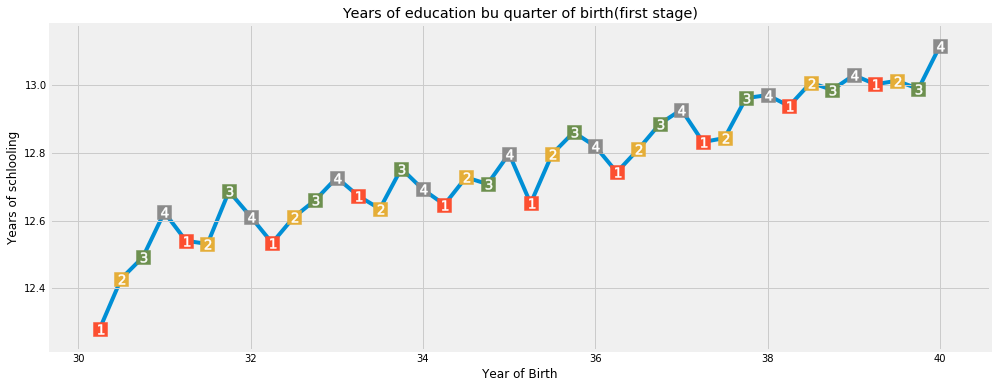

In [5]:
# 画图(T~ Z)
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"],group_data["years_of_schooling"],zorder=-1)

for q in range(1,5):
    x=group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y=group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x,y,s=200,c=f"C{q}",marker="s")     # # marker=s, 用正方形标记
    plt.scatter(x,y,s=100,c=f"white",marker=f"${q}$")  # marker= q, 用数字标记

plt.xlabel("Year of Birth")
plt.ylabel("Years of schlooling")
plt.title("Years of education bu quarter of birth(first stage)")

In [6]:
# 将第一阶段--线性回归（Z--T）
# 先将 z出生季度转换为虚拟变量

factor_data=data.assign(**{f"q{int(q)}":(data["quarter_of_birth"]==q).astype(int)
                         for q in data["quarter_of_birth"].unique()})
factor_data.head()

# T~ Z(q4)
first_stage=smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4",data=factor_data).fit()
print(first_stage.summary().tables[1])
print("q4 estiamtor:",first_stage.params["q4"])
print("q4 p-value:",first_stage.pvalues["q4"])


                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.3370      0.038    295.142      0.000      11.262      11.412
C(year_of_birth)[T.31.0]      0.1432      0.025      5.687      0.000       0.094       0.193
C(year_of_birth)[T.32.0]      0.2110      0.025      8.490      0.000       0.162       0.260
C(year_of_birth)[T.33.0]      0.2708      0.025     10.767      0.000       0.222       0.320
C(year_of_birth)[T.34.0]      0.3097      0.025     12.432      0.000       0.261       0.359
C(year_of_birth)[T.35.0]      0.3750      0.025     15.154      0.000       0.326       0.423
C(year_of_birth)[T.36.0]      0.4202      0.025     16.968      0.000       0.372       0.469
C(year_of_birth)[T.37.0]      0.4810      0.025     19.614      0.000       0.433       0.529
C(year_of_birth)[T.38.0]      0.5626      0.024     23.146  

Text(0.5,1,'log_wage by quarter of birth(first stage)')

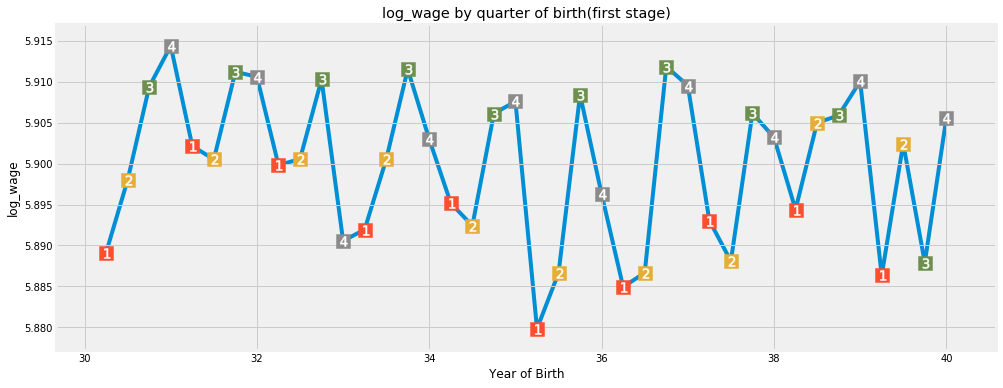

In [7]:
# 3.第二阶段 （Y~Z）
#画图（Y~Z）
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"],group_data["log_wage"],zorder=-1)

for q in range(1,5):
    x=group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y=group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x,y,s=200,c=f"C{q}",marker="s")     # # marker=s, 用正方形标记
    plt.scatter(x,y,s=100,c=f"white",marker=f"${q}$")  # marker= q, 用数字标记

plt.xlabel("Year of Birth")
plt.ylabel("log_wage")
plt.title("log_wage by quarter of birth(first stage)")

In [8]:
# 第二阶段线性回归(Y~ Z)
reduced_form =smf.ols("log_wage~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 estimator:",reduced_form.params["q4"])
print("q4 p-value:",reduced_form.params["q4"])

q4 estimator: 0.008603484260136315
q4 p-value: 0.008603484260136315


#在运用工具变量时，添加到第二阶段的其它控制变量也应该添加到第一阶段***

In [9]:
# 3. 手动计算工具变量
# 方法一：estimator(Y-Z)/estimator(T-Z)
ATE_iv=reduced_form.params["q4"]/first_stage.params["q4"]
ATE_iv

0.08530286492082695

In [10]:
# 方法二：Y--T_hat(T-Z)
T_hat=first_stage.fittedvalues
factor_data=factor_data.assign(T_hat=T_hat)
iv_by_hand=smf.ols("log_wage~ C(year_of_birth) + C(state_of_birth) + T_hat", data= factor_data).fit()
print(iv_by_hand.summary().tables[1])
print(iv_by_hand.params["T_hat"])

                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.7468      0.305     15.548      0.000       4.148       5.345
C(year_of_birth)[T.31.0]     -0.0078      0.007     -1.193      0.233      -0.021       0.005
C(year_of_birth)[T.32.0]     -0.0145      0.008     -1.875      0.061      -0.030       0.001
C(year_of_birth)[T.33.0]     -0.0174      0.009     -1.936      0.053      -0.035       0.000
C(year_of_birth)[T.34.0]     -0.0217      0.010     -2.200      0.028      -0.041      -0.002
C(year_of_birth)[T.35.0]     -0.0344      0.011     -3.033      0.002      -0.057      -0.012
C(year_of_birth)[T.36.0]     -0.0347      0.012     -2.791      0.005      -0.059      -0.010
C(year_of_birth)[T.37.0]     -0.0410      0.014     -2.945      0.003      -0.068      -0.014
C(year_of_birth)[T.38.0]     -0.0433      0.016     -2.710  

#手动计算，只能算一个estimoator值，没有有效的标准差。
#运用包linearmodels计算，可以获得有效的标准差。

In [69]:
# 4.运用包自动计算工具变量（2SLS）
# 定义输出的东西
def parase(model,exog="year_of_schooling"):
    param=model.params[exog]
    se=model.std_errors[exog]
    p_val=model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se)+param}")
    print(f"P-value:{p_val}")
    
#2SLS
formular="log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]"
iv2sls=IV2SLS.from_formula(formula,factor_data).fit()
parse(iv2sls)


NameError: name 'IV2SLS' is not defined

# 多个工具变量

In [12]:
# 多个工具变量
formula="log_wage~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3"
iv2sls_many=IV2SLS.from_formula(formula,factor_data).fit()
parse(iv2sls_many)

ValueError: formula not understood. Endogenous variables and instruments must be segregated in a block that starts with [ and ends with ].

# 工具变量的弱点

In [23]:
# 创建模拟数据
np.random.seed(12)
n=10000
X=np.random.normal(0,2,n)  # 观察到的变量 X
U=np.random.normal(0,2,n)  #未观察到的变量 U（忽略的变量）
T=np.random.normal(1 + 0.5*U, 5 , n)  #treatment变量
Y=np.random.normal(2 + X - 0.5*U + 2*T, 5 , n)  #Y变量

stddevs= np.linspace(0.1,100,50) 
Zs= {f"Z_{z}": np.random.normal(T,s,n) for z,s in enumerate(stddevs)} # IV 变量 with decreasing Cov(Z ,T)

sim_data=pd.DataFrame(dict(U=U,T=T,Y=Y)).assign(**Zs)
sim_data.head()

,U,T,Y,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,...,Z_40,Z_41,Z_42,Z_43,Z_44,Z_45,Z_46,Z_47,Z_48,Z_49
0,2.696148,8.056988,18.388910,8.233315,9.028779,16.430365,7.348864,4.848165,1.567900,16.654138,...,50.836515,-121.965878,-9.118833,-42.297891,17.015717,51.777219,78.678074,-164.581598,-117.798705,-13.485292
1,2.570240,0.245067,2.015052,0.455988,-0.901285,-6.442245,-2.824902,7.327944,-9.643833,14.237652,...,29.966537,141.855092,79.040440,66.249629,-23.107153,25.007034,-73.621303,85.867339,-209.727577,-70.792948
2,0.664741,5.597510,11.939170,5.528384,6.148148,10.141348,18.923875,-5.550785,4.495364,-14.070897,...,-29.051441,14.537511,-95.846490,-117.922132,43.194916,58.534855,119.820024,-173.513340,60.562232,47.619414
3,1.037725,0.493532,-5.077869,0.382075,0.790127,-2.753808,3.146698,-7.152174,-6.322238,9.209916,...,-61.446478,26.719702,-40.753912,63.725307,22.462409,97.200099,-116.309759,-26.328707,78.136513,-108.322304
4,-2.590591,-6.263014,-6.460508,-6.197533,-5.954731,-19.295207,-11.343303,-7.231806,5.556399,-17.913401,...,-28.071993,146.111732,-21.991256,88.258432,62.211154,-72.066362,51.848504,-117.858043,78.776566,-80.547214


In [36]:
# 检查 cov(z,T)
sim_data.corr()   # 查看表内所有变量之间的相关系数
cov_T= sim_data.corr()["T"]    # 产看表内所有变量与T之间的相关系数
corr=cov_T[cov_T.index.str.startswith("Z")]   # 选取index以Z开头的
corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

In [ ]:
# # 为每一个工具变量运行2SLS
se=[]    #将标准差装进se
ate= []    #将ate装进ate
for z in range(len(Zs)):
    formula=f"Y~1+X+[T~{Zs}]"
    iv=IV2SLS.from_formula(formula,sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

In [ ]:
# 画图
plot_data=pd.DataFrame(dict(se=se,ate=ate,corr=corr))
plt.scatter(plot_data["corr"],plot_data["se"]

#结论：Z与T的相关性越小，则最后的IV估计出的ATE的标准差越大。